# Plotting Light Curves

In [1]:
%matplotlib inline
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib import style
style.use('seaborn-white')
import pandas as pd
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle
from astropy import units as u
from astropy.table import QTable
import tarfile
import sqlite3
import lsst.daf.persistence as dafPersist
from lsst.daf.base import DateTime

sys.path.append('/epyc/users/mrawls/ap_pipe-notebooks/')
import diaObjectAnalysis as doa
import plotLightcurve as plc
import apdbPlots as pla

ImportError: cannot import name 'UnpackApdbFlags' from 'lsst.ap.association' (/epyc/users/mrawls/lsst_stack/stack/miniconda3-4.5.12-f032070/Linux64/ap_association/18.1.0-14-g371438c+1/python/lsst/ap/association/__init__.py)

In [3]:
# Full dataset
hitsDataDir='/epyc/users/mrawls/premap2019/hits-dr1/classification'
hitsFilename='HiTS_RF_predictions.fits'
hitsFilepath=os.path.join(hitsDataDir,hitsFilename)
hitsTable=fits.open(hitsFilepath) # load data as an astropy fits thing
hitsDf=pd.DataFrame(hitsTable[1].data) # turn data into a pandas dataframe
hitsDf.head() # shows us what the dataframe looks like

,ID,internalID,raMedian,decMedian,Variable_prob,Periodic_prob,DSCT_Prob,EB_Prob,ROTVAR_Prob,RRLYR_Prob,CV_Prob,QSO_Prob,SNe_Prob,Predicted_class
0,HiTS090434-041626,Blind15A_02_S1_1856_0087,136.145756,-4.273908,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NV
1,HiTS090434-042338,Blind15A_02_N1_1253_0089,136.145561,-4.394096,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NV
2,HiTS090434-042506,Blind15A_02_N1_1587_0054,136.142838,-4.418445,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NV
3,HiTS090434-042629,Blind15A_02_N1_1903_0088,136.145272,-4.441517,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NV
4,HiTS090435-000829,Blind15A_04_S1_0030_0051,136.146090,-0.141399,0.033194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NV


In [4]:
# Subset
hitsDataDir_sub='/epyc/users/mrawls/premap2019/hits-dr1'
hitsFilename_sub='HiTS_DR1_variables_DM-dataset-subset.fits'
hitsFilepath_sub=os.path.join(hitsDataDir_sub,hitsFilename_sub)
hitsTable_sub=fits.open(hitsFilepath_sub) # load data as an astropy fits thing
hitsDf_sub=pd.DataFrame(hitsTable_sub[1].data) # turn data into a pandas dataframe
hitsDf_sub.head() # shows us what the dataframe looks like

,ID,internalID,raMedian,decMedian,Variable_prob,Periodic_prob,DSCT_Prob,EB_Prob,ROTVAR_Prob,RRLYR_Prob,...,Rcs,Skew,SlottedA_length,SmallKurtosis,Std,StetsonK,StetsonK_AC,g-i,g-r,r-i
0,HiTS095611+020452,Blind15A_26_N1_1715_0146,149.048038,2.081381,0.523601,0.202651,NaN,NaN,NaN,NaN,...,0.246009,-0.584446,0.134705,2.100608,0.032812,0.773151,0.738233,2.859381,1.439736,1.419645
1,HiTS095645+021135,Blind15A_26_N1_0181_2093,149.190225,2.193068,0.564932,0.635018,0.400,0.100,0.375,0.125,...,0.119267,-0.133774,0.067353,-0.444997,0.123052,0.841553,0.815632,0.996040,0.769289,0.226751
2,HiTS095652+023537,Blind15A_26_S14_1446_0379,149.220445,2.593841,0.962477,0.635836,0.025,0.125,0.750,0.100,...,0.227995,-0.317121,0.269410,-0.008631,0.067782,0.849505,0.846981,1.911452,1.484048,0.427403
3,HiTS095702+023628,Blind15A_26_S14_1253_0945,149.261780,2.607883,0.532390,0.933333,0.550,0.225,0.050,0.175,...,0.179956,-0.288333,0.067353,-1.067079,0.181790,0.853063,0.754798,NaN,NaN,NaN
4,HiTS095726+015556,Blind15A_26_N8_1496_2317,149.361376,1.932343,0.972280,0.889344,0.050,0.175,0.625,0.150,...,0.269737,-0.035972,0.740878,-1.731678,0.089139,0.957841,0.948092,1.185192,0.894064,0.291128


In [5]:
#creating dataframes for the QSOs
hitsDfQSO = hitsDf[hitsDf['QSO_Prob'] > 0.80]
hitsDfQSO_sub = hitsDf_sub[hitsDf_sub['QSO_Prob'] > 0.80]
len(hitsDfQSO_sub), len(hitsDfQSO)

(20, 630)

### Just HiTS for now

In [6]:
def plot_hits_full(row, lcPath='/epyc/users/tw94/light_curves_full'):
    '''Plots light curves from HiTS DR1.
    
    Parameters
    ----------
    row : Pandas Dataframe row from DR1 source data
    lcPath : Path on disk to light curves from DR1
    '''
    tok = row['internalID'].split('_')
    field = '_'.join([tok[0], tok[1]])
    ccd = tok[2]
    lightcurveFile = field + '_' + ccd + '_LC_50.tar.gz'
    tarball = tarfile.open(os.path.join(lcPath, field, ccd, lightcurveFile))
    data = tarball.extractfile(row['internalID'].rstrip() + '_g.dat')
    dfl = pd.read_csv(data, sep='\t')  # load a file with light curve data into a pandas dataframe
    fig = plt.figure(figsize=(10, 8))
    plt.errorbar(dfl.MJD, dfl.MAG_AP1, dfl.MAGERR_AP1, marker='o', linestyle=':')
    plt.xlabel('Time (MJD)')
    plt.ylabel('magnitude')

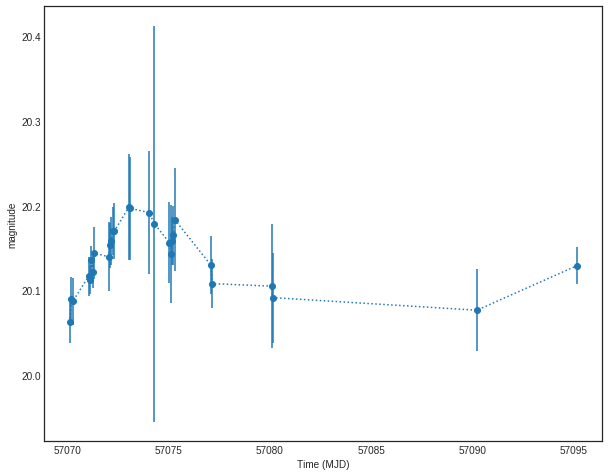

In [7]:
plot_hits_full(hitsDfQSO.iloc[35])

NameError: name 'hitsDfQSO' is not defined

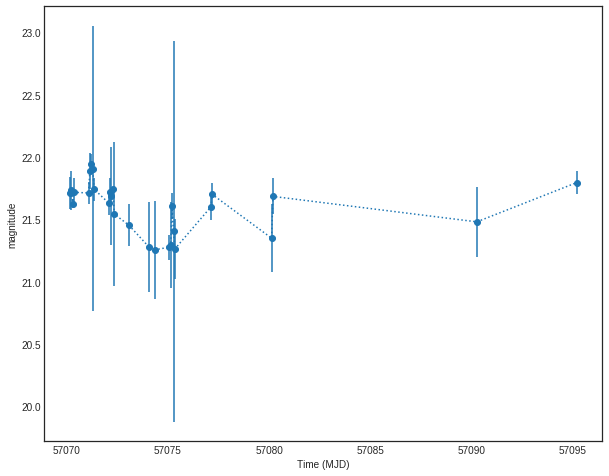

In [8]:
plot_hits_full(hitsDfQSO_sub.iloc[19])

### HiTS and LSST on the Same Plot

In [9]:
repo = '/epyc/users/mrawls/hits2015/rerun/cw_2020_02'
butler = dafPersist.Butler(repo)

In [10]:
dbName = 'association.db'
dbPath = os.path.join(repo, dbName)

In [11]:
connection = sqlite3.connect(dbPath)

In [12]:
objTable = pd.read_sql_query('select diaObjectId, ra, decl, nDiaSources, \
                              gPSFluxMean, gPSFluxMeanErr, \
                              validityEnd, flags, \
                              gTOTFluxMean, gTOTFluxMeanErr \
                              from DiaObject where validityEnd is NULL;', connection)

In [13]:
srcTableAll = pd.read_sql_query('select diaSourceId, diaObjectId, \
                                  ra, decl, ccdVisitId, \
                                  midPointTai, apFlux, psFlux, apFluxErr, \
                                  psFluxErr, totFlux, totFluxErr, flags \
                                  from DiaSource;', connection)

In [14]:
badFlagList = ['base_PixelFlags_flag_bad', 'base_PixelFlags_flag_suspect', 'base_PixelFlags_flag_saturatedCenter']

In [15]:
flagTable, flagValues, srcTableFlags, flagFilter, noFlagFilter, \
    goodSrc, goodObj = makeSrcTableFlags(srcTableAll, objTable)

NameError: name 'makeSrcTableFlags' is not defined

In [16]:
lsstQSORas = goodObj.ra
lsstQSODecs = goodObj.decl
hitsQSORas = hitsDfQSO_sub.raMedian_feat
hitsQSODecs = hitsDfQSO_sub.decMedian_feat

NameError: name 'goodObj' is not defined

In [17]:
hitsQSOCoords = SkyCoord(ra=hitsQSORas*u.degree, dec=hitsQSODecs*u.degree)
lsstQSOCoords = SkyCoord(ra=lsstQSORas*u.degree, dec=lsstQSODecs*u.degree)
idxRef, d2d, d3d = hitsQSOCoords.match_to_catalog_sky(lsstQSOCoords)

NameError: name 'hitsQSORas' is not defined

In [18]:
def plotTwoLightcurves(idx, hitsDf, matchIndices, 
                       dbPath='/epyc/users/mrawls/hits2015/rerun/cw_2020_02/association.db',
                       lcPath='/epyc/users/tw94/light_curves_full',
                       plotSourceCatLightCurve=False,
                       NSources=10):
    '''Plot a light curve for a DIA (Difference Image Analysis) Object
    from an LSST APDB (Alert Production database), and plot the light curve
    for the same object as measured by the HiTS data release.
    
    Parameters
    ----------
    idx : integer
        specify which of 0-164 HiTS DR1 variables you would like to plot
    hitsDf : Pandas Dataframe containing containing variable objects (HiTS) info
    matchIndices : list or array of integers
        the indices are for lsstCoords corresponding to hitsCoords 0, 1, 2, ...
    

    dbPath : Path on disk to an APDB we can load DIA Objects or DIA Sources from
        often the database is named `association.db`
    lcPath : Path on disk to light curves from HiTS DR1
    plotSourceCatLightCurve : boolean, try retrieving source catalog fluxes from LSST for comparison?
        default is False, this is slow but more accurate than forced photometry

    '''
    # Check and see if there are more than NSources comprising the Object, and decide whether to plot it or not
    if goodObj.iloc[matchIndices[idx]]['nDiaSources'] < NSources:
        print(f'Skipping HiTS index {idx} (LSST index {matchIndices[idx]}), fewer than {NSources} DIA Sources in the LSST DIA Object')
        return

    # Use the match index to retrieve the DIA Object ID
    obj = goodObj.iloc[matchIndices[idx]]['diaObjectId']
        
    # Load all sources for this object only
    connection = sqlite3.connect(dbPath)
    forcedSrcTable = pd.read_sql_query(f'select diaObjectId, midPointTai, psFlux, psFluxErr, totFlux, totFluxErr \
                                       from DiaForcedSource where diaObjectId = {obj};', connection)
    srcTable = pd.read_sql_query(f'select diaObjectId, midPointTai, ccdVisitId, psFlux, psFluxErr, totFlux, totFluxErr \
                                 from DiaSource where diaObjectId = {obj};', connection)

    # Convert flux to magnitude
    mags = (np.array(forcedSrcTable['totFlux'])*u.nJy).to(u.ABmag)
    magErrs = 1.0857 / forcedSrcTable['totFluxErr'] / forcedSrcTable['totFlux']
    forcedSrcTable['mags'] = mags
    forcedSrcTable['magErrs'] = magErrs
    
    mags = (np.array(srcTable['totFlux'])*u.nJy).to(u.ABmag)
    magErrs = 1.0857 / srcTable['totFluxErr'] / srcTable['totFlux']
    srcTable['mags'] = mags
    srcTable['magErrs'] = magErrs
    
    plt.figure(figsize=(10,4))
    
    # Retrieve the correct row from the HiTS DR1 dataframe for plotting
    # Use the information in that row to retrieve a HiTS light curve file
    hitsRow = hitsDf.iloc[idx]
    tok = hitsRow['internalID'].split('_')
    field = '_'.join([tok[0], tok[1]])
    ccd = tok[2]
    lightcurveFile = field + '_' + ccd + '_LC_50.tar.gz'
    tarball = tarfile.open(os.path.join(lcPath, field, ccd, lightcurveFile))
    data = tarball.extractfile(hitsRow['internalID'].rstrip() + '_g.dat')
    dfl = pd.read_csv(data, sep='\t')  # load a file with light curve data into a pandas dataframe
    
    # Get some fun classification info about the object from HiTS
    predicted_class = hitsRow['Predicted_class'].strip()
    class_probability = hitsRow[f"{predicted_class}_Prob"]
    
    # Plot the LSST light curve (forced PSF photometry on calexp at DIASource position)
    #plt.errorbar(srcTable['midPointTai'], srcTable['mags'], 
    #             yerr=srcTable['magErrs'], ls=':', marker='o', label='LSST Source', color='C0')
    
    # Plot the LSST light curve (forced PSF photometry on calexp at DIAObject position)
    plt.errorbar(forcedSrcTable['midPointTai'], forcedSrcTable['mags'], 
                 yerr=forcedSrcTable['magErrs'], ls=':', marker='o', label='LSST', color='C0')
    
    # Plot the LSST light curve directly from source catalogs
    if plotSourceCatLightCurve:
        objTable = pd.read_sql_query('select diaObjectId, ra, decl, nDiaSources \
                              from DiaObject where validityEnd is NULL;', connection)
        sourceCatTimes, sourceCatMags, sourceCatMagErrs = getSourceCatLightCurve(obj, objTable, srcTable, butler)
        plt.errorbar(sourceCatTimes, sourceCatMags, yerr=sourceCatMagErrs, ls=':', marker='o', label='LSST SourceCat', color='C2')
    
    # Plot the HiTS light curve
    plt.errorbar(dfl.MJD, dfl.MAG_AP1, dfl.MAGERR_AP1, marker='o', ls=':', label='HiTS', color='C3')

    # Add some plot labels, and reverse the y-axis so bright stuff is at the top
    plt.gca().invert_yaxis()
    plt.xlabel('Time (MJD)')
    plt.ylabel('magnitude')
    #plt.title(f"HiTS index: {idx} | LSST index: {matchIndices[idx]} | {predicted_class} Probability: {class_probability:0.2f}")
    plt.title(f"HiTS classification: {predicted_class} | Probability: {class_probability:0.2f}")
    plt.legend(frameon=False, prop={'size': 16})

In [19]:
def getSourceCatLightCurve(obj, objTable, srcTable, butler):
    '''Retrieve source catalog flux for a DIA Object.
    Parameters
    ----------
    obj : DIA Object ID
    objTable : DIA Object table containing one row for object "obj", as a Pandas Dataframe
    srcTable : DIA Source table containing sources associated into "obj", as a Pandas Dataframe
    butler : LSST Science Pipelines Butler instance, for accessing source catalog data
    Returns
    -------
    sourceCatTimes : list of times for "obj"
    sourceCatMags : list of magnitudes for "obj"
    sourceCatMagErrs : list of magnitude errors for "obj"
    '''
    skyCoordObj = SkyCoord(objTable['ra'], objTable['decl'], unit=u.deg)
    sourceCatTimes = []
    sourceCatMags = []
    sourceCatMagErrs = []
    for visit in srcTable['ccdVisitId']: 
        dataId = {'visit': int(str(visit)[0:6]), 'ccdnum': int(str(visit)[6:])}
        visit_info = butler.get('calexp_visitInfo', dataId=dataId)
        time = visit_info.getDate().get(system=DateTime.MJD)
        sourceCatTimes.append(time)
        photoCalib = butler.get('calexp_photoCalib', dataId=dataId)
        calsrc = butler.get('src', dataId=dataId)  # this is the full source catalog for that visitID
        calsrcAstropy = calsrc.asAstropy()
        # Find the single source that matches most closely with our object RA and Dec
        calsrcSkyCoord = SkyCoord(calsrcAstropy['coord_ra'], calsrcAstropy['coord_dec'], unit=u.rad)
        matchIdx, matchAngle, match3d = skyCoordObj.match_to_catalog_sky(calsrcSkyCoord)
        calibMag = photoCalib.instFluxToMagnitude(calsrc, 'base_PsfFlux')[matchIdx]
        sourceCatMags.append(calibMag[0,0])
        sourceCatMagErrs.append(calibMag[0,1])
    return sourceCatTimes, sourceCatMags, sourceCatMagErrs

In [20]:
plotTwoLightcurves(41435, hitsDf=goodObj, matchIndices=idxRef, plotSourceCatLightCurve=False, NSources=1)

NameError: name 'goodObj' is not defined

### Searching for Quasars

In [17]:
hitsDfQSO.head()

,ID,internalID,raMedian,decMedian,Variable_prob,Periodic_prob,DSCT_Prob,EB_Prob,ROTVAR_Prob,RRLYR_Prob,CV_Prob,QSO_Prob,SNe_Prob,Predicted_class
2668,HiTS090524-041110,Blind15A_02_S1_0648_2891,136.350909,-4.186367,0.666667,0.174381,NaN,NaN,NaN,NaN,0.025,0.975,0.000,QSO
4891,HiTS090543-041323,Blind15A_02_S1_1148_3999,136.431651,-4.223211,0.565097,0.266667,NaN,NaN,NaN,NaN,0.150,0.825,0.025,QSO
7190,HiTS090602-040245,Blind15A_02_S8_0977_2949,136.510771,-4.045886,0.691463,0.070836,NaN,NaN,NaN,NaN,0.025,0.950,0.025,QSO
7548,HiTS090604-044418,Blind15A_02_N14_1454_3046,136.516803,-4.738595,0.595645,0.300219,NaN,NaN,NaN,NaN,0.100,0.900,0.000,QSO
8304,HiTS090610-000337,Blind15A_04_S8_1177_3373,136.543299,-0.060552,0.900000,0.438464,NaN,NaN,NaN,NaN,0.125,0.850,0.025,QSO


In [18]:
hitsDfQSO_highprob = hitsDfQSO_sub[hitsDfQSO_sub['QSO_Prob'] > .90]
hitsDfQSO_highprob

,ID,internalID,raMedian,decMedian,Variable_prob,Periodic_prob,DSCT_Prob,EB_Prob,ROTVAR_Prob,RRLYR_Prob,...,Rcs,Skew,SlottedA_length,SmallKurtosis,Std,StetsonK,StetsonK_AC,g-i,g-r,r-i
19,HiTS095906+023411,Blind15A_26_S15_1778_3732,149.775547,2.569846,0.700000,0.390697,NaN,NaN,NaN,NaN,...,0.420546,-0.594354,0.875583,-0.062144,0.024636,0.822118,0.880237,-1.334129,-1.042169,-0.291960
35,HiTS100126+012007,Blind15A_26_N31_0662_1083,150.358619,1.335401,0.520305,0.436615,NaN,NaN,NaN,NaN,...,0.285576,0.140620,0.202452,-1.167321,0.085182,0.859821,0.807446,1.105655,0.707078,0.398576
40,HiTS100158+015816,Blind15A_26_N12_0952_0771,150.492562,1.971313,0.700000,0.277657,NaN,NaN,NaN,NaN,...,0.362111,-0.584109,0.134705,-0.046382,0.035685,0.870675,0.803572,0.573734,0.385713,0.188021
58,HiTS101701-062013,Blind15A_40_S8_1964_0931,154.254351,-6.337102,0.800000,0.498545,NaN,NaN,NaN,NaN,...,0.329587,0.344962,0.874909,-0.687273,0.035174,0.892263,0.834892,0.826516,0.595061,0.231455
121,HiTS102128-064630,Blind15A_40_N11_1175_3317,155.367578,-6.775014,0.765481,0.407337,NaN,NaN,NaN,NaN,...,0.398964,0.623115,0.269203,-0.152664,0.023314,0.840538,0.818118,0.735066,0.553852,0.181214


No MILLIQUAS Results (Maybe I need to convert the units)
SIMBAD Results:
1. COSMOS2015 831868 - Star (AGN ACS-GC 20155784 kind of close to this)
2. 2dFGRS TGN420Z048 or 2dFGRS TGN420Z043 - Galaxies
3. SDSS J100158.16+015815.9 - Star
4. LEDA 1034047 - Galaxy
5. LCRS B101851.3-063155 - Galaxy

In [19]:
QSOCoords = QTable([hitsDfQSO_sub['raMedian'],hitsDfQSO_sub['decMedian']], names = ('raMedian','decMedian'))
QSOCoords['raMedian'].unit = u.deg
QSOCoords['decMedian'].unit = u.deg
QSOAngleRa = Angle(QSOCoords['raMedian'])
QSOAngleDec = Angle(QSOCoords['decMedian'])
QSOAngleDec


<Angle [ 1.51455358,  2.56984556,  1.33540056,  1.97131275,  1.70188751,
         2.60685674, -6.33710247, -6.94139221, -7.25555257, -4.42341461,
        -6.72969862, -5.62906767, -4.06288659, -5.75133278, -4.68807938,
        -6.77501353, -4.18314206, -7.24999939, -5.22358621, -4.30217501] deg>

In [20]:
import re

In [21]:
RA = []
for i in range(20):
    coordra = str(re.sub('[_tuple()h=,ms]', '', str(QSOAngleRa[i].hms)))
    RA.append(coordra)
RA[0].strip('*.0 *') #WHY WONT YOU GO AWAY??

'9.0 58.0 24.96163608000515'

In [22]:
DEC = []
for i in range(20):
    coorddec = re.sub('[dms]', ' ', str(QSOAngleDec[i]))
    DEC.append(coorddec)

In [23]:
MILLIQUASCoords = pd.DataFrame({"RA":RA,"DEC":DEC})

MILLIQUASCoords

,RA,DEC
0,9.0 58.0 24.96163608000515,1 30 52.3929
1,9.0 59.0 6.131255760005985,2 34 11.444
2,10.0 1.0 26.068495200002104,1 20 07.442
3,10.0 1.0 58.214883840007445,1 58 16.7259
4,10.0 2.0 3.3325365600066448,1 42 06.795
5,10.0 3.0 12.030879360007845,2 36 24.6843
6,10.0 17.0 1.0443441600077108,-6 20 13.5689
7,10.0 18.0 16.815862800005448,-6 56 29.012
8,10.0 18.0 52.233567360010795,-7 15 19.9893
9,10.0 19.0 3.1864783200076374,-4 25 24.2926


#### Zero matches in MILLIQUAS for our subset. Note: used a search radius of 5 arcmin to account for source coordinate offset.

In [24]:
ra_range1 = [154,156.5]*u.deg
ra_range2 = [149,151.5]*u.deg
dec_range1 = [-3.5,-7.5]*u.deg
dec_range2 = [1,3.25]*u.deg

In [26]:
rangeQ = QTable([ra_range1,dec_range1,ra_range2,dec_range2], names = ('RA 1', 'DEC 1', 'RA 2', 'DEC 2'))
rangeQAngleRa1 = Angle(rangeQ['RA 1'])
rangeQAngleDec1 = Angle(rangeQ['DEC 1'])
rangeQAngleRa2 = Angle(rangeQ['RA 2'])
rangeQAngleDec2 = Angle(rangeQ['DEC 2'])
rangeQ

RA 1,DEC 1,RA 2,DEC 2
deg,deg,deg,deg
float64,float64,float64,float64
154.0,-3.5,149.0,1.0
156.5,-7.5,151.5,3.25


In [27]:
RA1 = []
for i in range(2):
    coordra1 = str(re.sub('[_tuple()h=,ms]', '', str(rangeQAngleRa1[i].hms)))
    RA1.append(coordra1)
RA2 = []
for i in range(2):
    coordra2 = str(re.sub('[_tuple()h=,ms]', '', str(rangeQAngleRa2[i].hms)))
    RA2.append(coordra2)
DEC1 = []
for i in range(2):
    coorddec1 = re.sub('[dms]', ' ', str(rangeQAngleDec1[i]))
    DEC1.append(coorddec1)
DEC2 = []
for i in range(2):
    coorddec2 = re.sub('[dms]', ' ', str(rangeQAngleDec2[i]))
    DEC2.append(coorddec2)
    
MILLIQUASCoords2 = pd.DataFrame({"RA 1":RA1,"DEC 1":DEC1,"RA 2":RA2,"DEC 2":DEC2})

MILLIQUASCoords2

,RA 1,DEC 1,RA 2,DEC 2
0,10.0 16.0 9.379164112033322-12,-3 30 00,9.0 56.0 7.247535904753022-12,1 00 00
1,10.0 26.0 7.247535904753022-12,-7 30 00,10.0 6.0 5.115907697472721-12,3 15 00


#### Hundreds of results for each -- does our software suck?

make magnitude cuts based on Forester HiTS Paper

Plot ra and dec for the Milliquas database for the ra and dec ranges.

Maybe no variability over our timeperiod